# Households Power Consumption - LSTM  

Source
- https://archive.ics.uci.edu/ml/machine-learning-databases/00235/
- https://data.world/databeats/household-power-consumption

> Individual household electric power consumption dataset collected via submeters placed in 3 distinct areas of a home  
__Data Set Information__  
This household electricity consumption dataset contains 260,640 measurements gathered between January 2007 and June 2007 (6 months). It is a subset of a larger, original archive that contains 2,075,259 measurements gathered between December 2006 and November 2010 (47 months).  
Attribute Information  
date: Date in format dd/mm/yyyy  
time: time in format hh:mm:ss  
global_active_power: household global minute-averaged active power (in kilowatt)  
global_reactive_power: household global minute-averaged reactive power (in kilowatt)  
voltage: minute-averaged voltage (in volt)  
global_intensity: household global minute-averaged current intensity (in ampere)  
sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
Notes
(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.
Original Source
Georges Hébrail, (georges.hebrail '@' edf.fr), Senior Researcher, EDF R&D, Clamart, France
Alice Bérard, TELECOM ParisTech Master of Engineering Internship at EDF R&D, Clamart, France
Provider
This dataset was downloaded from the UCI Machine Learning Repository on 11/8/2016

## Import Packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time
import csv
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.layers import LSTM, RNN, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential

from sklearn import preprocessing
from sklearn import model_selection

np.random.seed(1234)

Using TensorFlow backend.


## Prepare Dataset

In [3]:
path_to_dataset = './../dataset/household_power_consumption.txt'

def import_data(n_dataset = 10000, ratio = 1.0):
    stime_read = time.time()
    print('Importing household power consumption data : ' + path_to_dataset + '  ......')
    data = pandas.read_csv(path_to_dataset,
                            #nrows = n_dataset,
                            index_col=0,
                            delimiter=";", 
                            parse_dates=[[0,1]],
                            #low_memory = False,
                            #dtype = {'Global_active_power':np.float64,'Global_reactive_power':np.float64,'Voltage':np.float64,'Global_intensity':np.float64,'Sub_metering_1':np.int64,'Sub_metering_2':np.int64,'Sub_metering_3':np.int64},
                            infer_datetime_format=True)
    ftime_read = time.time()
    print('Finished Importing: %.2f sec' % (ftime_read - stime_read))
    return data.infer_objects()
data = import_data().convert_objects(convert_numeric=True)
print(data.dtypes)
data.head()

Importing household power consumption data : ./../dataset/household_power_consumption.txt  ......
Finished Importing: 19.74 sec
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [43]:
# Regroup data by 'Day'
df_ave = data[['Global_active_power','Global_reactive_power','Voltage','Global_intensity']].resample('3T', how = 'mean')

# Normalization
normalized_df=(df_ave-df_ave.mean())/df_ave.std() # mean/std normalization
#normalized_df=(df_ave-df_ave.min())/(df_ave.max()-df_ave.min()) # min/max normalization

print(normalized_df.shape)
normalized_df.head()

(691753, 4)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity
Date_Time,,,,
2006-12-16 17:24:00,3.734962,2.994011,-2.152105,3.845956
2006-12-16 17:27:00,2.974856,3.604506,-1.874272,3.038946
2006-12-16 17:30:00,2.493712,3.598401,-1.888785,2.551695
2006-12-16 17:33:00,3.278131,3.378623,-2.386397,3.404385
2006-12-16 17:36:00,3.605718,2.829178,-2.216380,3.708917


### Visualize Data

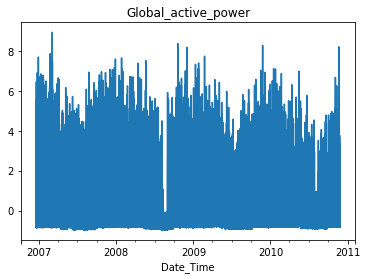

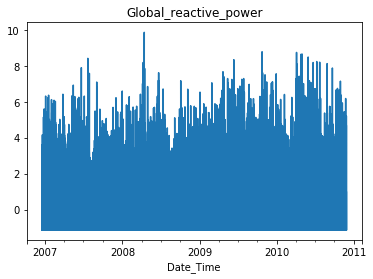

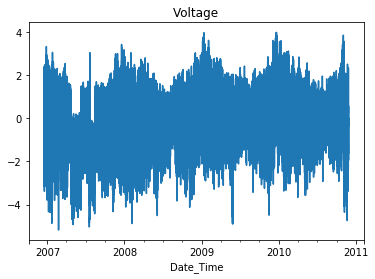

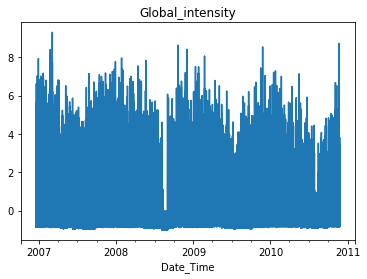

In [44]:
for column in normalized_df:
    plt.figure()
    normalized_df[column].plot(title=column)

In [45]:
def get_Xy(data, D=30): # Collect data by D-days. (30 - month, 7 - week)
    # make X and y
    X_l = []
    y_l = []
    N = len(data)
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1):
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y

X, y = get_Xy(normalized_df.values.T[0], D=30) # Grouping
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

(691722, 30, 1) (691722,)


In [32]:
def data_power_consumption(sequence_length=50, ratio=1.0):

    max_values = ratio * 2049280

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break


    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]
X_train2, y_train2, X_test2, y_test2 = data_power_consumption()

## Model

In [52]:
# Define Model
model = Sequential()

model.add(LSTM(50,
            input_shape = (None,1),
            return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "linear"))

# Set Compiling
model.compile(loss="mean_squared_error",
              optimizer="adam")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


## Training

In [54]:
epochs = 10
global_start_time = time.time()
print('Data Loaded. Compiling...')

try:
    history = model.fit(
        X_train, y_train,
        #batch_size=256,
        nb_epoch=epochs,
        validation_data=[X_test, y_test],
        verbose = 1)
    predicted = model.predict(X_test)
    predicted = np.reshape(predicted, (predicted.size,))
except KeyboardInterrupt:
    print('Training duration (s) : ', time.time() - global_start_time)
print('Total Training Duration (s) : ', time.time() - global_start_time)

Data Loaded. Compiling...
Train on 553377 samples, validate on 138345 samples
Epoch 1/10
  4160/553377 [..............................] - ETA: 24:30 - loss: nanTraining duration (s) :  11.235073804855347
Total Training Duration (s) :  11.238300800323486


## Result and Analysis

In [55]:
# Prediction Result
ypredict = model.predict(X_test)

print('Loss:', model.evaluate(X_test, y_test))
print('predict shape: ', ypredict.shape, 'test shape: ', y_test.shape)

plt.plot(ypredict, label='Train')
plt.plot(y_test  , label='Predict')
plt.legend(loc=0)
plt.title('Results')
plt.show()

KeyboardInterrupt: 

In [56]:
# Display Loss History
def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    plt.show()
    
plot_loss(history, 'Loss History')

NameError: name 'history' is not defined